# Reconstruction de synonymes - correction

En résumé :

* les synonymes via la base [WOLF](http://alpage.inria.fr/~sagot/wolf-en.html)
* on ne garde que les synonymes composé d'un seul mot
* on prend ensuite un texte quelconque qu'on découpe en phrase
* pour chaque phrase qu'on rencontre, on remplace des mots au hasard par leur synonymes
* chaque phrase sera présente une fois à l'identique et plusieurs fois avec des synonymes différents

L'objectif est alors de proposer une méthode pour reconstruire la base de synonymes.

In [ ]:
from pyquickhelper.ipythonhelper import add_notebook_menu
add_notebook_menu()

## Génération des données

### Construction de la base de synonymes

In [ ]:
from actuariat_python.data import wolf_xml
wolf_xml()

['.\\wolf-1.0b4.xml.', 'debvisdic-strict.dtd']

In [ ]:
from actuariat_python.data import enumerate_wolf_synonyms
for syn in enumerate_wolf_synonyms("wolf-1.0b4.xml"):
    print(syn)
    break

['respirer', 'inspirer']


On passe en revue toute la basse (il y a environ 120.000 lignes) et on s'arrête après 10000 synonymes car sinon, cela prend un temps fou.

In [ ]:
allsyn = {}
for line, syn in enumerate(enumerate_wolf_synonyms("wolf-1.0b4.xml")):
    if line % 10000 == 0: print("line", line, "allsyn", len(allsyn))
    clean = [_.lower() for _ in syn if " " not in _]
    if len(clean) > 1:
        for word in clean:
            if word not in allsyn:
                allsyn[word] = set(clean)
                continue
            else:
                for cl in clean:
                    allsyn[word].add(cl)
    if len(allsyn) > 10000:
        break
len(allsyn)

line 0 allsyn 0


10002

On affiche les premiers groupes :

In [ ]:
i = 0
for k, v in allsyn.items():
    print(k,v)
    i += 1
    if i > 10:
        break

commerciable {'commercialisable', 'commerciable'}
réformer {'corriger', 'rectifier', 'amender', 'remédier', 'libérer', 'améliorer', 'délivrer', 'réformer'}
herbe {'voile', 'croisière', 'herbe'}
bancal {'vacillant', 'vieux', 'branlant', 'délabré', 'chambranlant', 'bancal', 'caduc', 'chancelant', 'boiteux'}
querelle {'différend', 'dispute', 'querelle', 'litige', 'contravention'}
explicitement {'clairement', 'explicitement', 'évidemment', 'univoquement'}
extraconjugal {'adultère', 'extraconjugal'}
méticuleusement {'méticuleusement', 'soigneusement'}
épaulé-jeté {'propre', 'épaulé-jeté', 'pur'}
arcade {'arcade', 'arc'}
majoritairement {'primordialement', 'majoritairement'}


### Génération d'une base de phrases modifiées

On utilise [Zadig](https://fr.wikipedia.org/wiki/Zadig).

In [ ]:
import urllib.request
with urllib.request.urlopen("http://www.gutenberg.org/cache/epub/4647/pg4647.txt") as u:
    content = u.read()

In [ ]:
char = content.decode(encoding="utf-8")

On découpe en mot.

In [ ]:
import re
reg = re.compile("([- a-zA-Zâàäéèëêîïôöùûü']+)")
phrases = [_.lower() for _ in reg.findall(char)]

In [ ]:
for i, phrase in enumerate(phrases):
    if i >= 990:
        print(phrase)
    if i >= 1000:
        break

desterham
 il parla en ces termes
toiles de justice
 abîmes de science
 miroirs de vérité
 qui
avez la pesanteur du plomb
 la dureté du fer
 l'éclat du diamant
et beaucoup d'affinité avec l'or
 puisqu'il m'est permis de


On génère les phrases modifiées :

In [ ]:
import random
def modification(phrase, allsyn, nmax=10):
    mots = phrase.split()
    options = []
    nb = 1
    for mot in mots:
        if mot in allsyn:
            options.append(list(set([mot] + list(allsyn[mot]))))
        else:
            options.append([mot])
        nb *= len(options[-1])
    if nb == 1:
        return [phrase]
    else:
        res = []
        for i in range(0, min(nmax, nb//2+1, nb)):
            sol = []
            for mot in options:
                h = random.randint(0, len(mot)-1)
                sol.append(mot[h])
            res.append(sol)
        return res
            
modification("chatouiller le cérébral", allsyn)

[['vibrer', 'le', 'intellectuel'],
 ['chatouiller', 'le', 'obscur'],
 ['chatouiller', 'le', 'intellectuel'],
 ['chatouiller', 'le', 'ésotérique'],
 ['chatouiller', 'le', 'cérébral']]

On traite tous les mots :

In [ ]:
len(phrases)

7099

In [ ]:
with open("zadig_augmente.txt", "w", encoding="utf-8") as f:
    total = 0
    init = 0
    for i, phrase in enumerate(phrases):
        augm = modification(phrase, allsyn)
        init += 1
        for au in augm:
            f.write(" ".join(au) + "\n")
            total += 1
"total", total, "initial", init

('total', 32358, 'initial', 7099)

## Exercice : retrouver une partie des synonymes à partir du dernier fichier créé

Le fichier utilisé peut être généré à partir du code précédent ou utiliser cette version : [zadig_augmente.zip](http://www.xavierdupre.fr/enseignement/complements/zadig_augmente.zip).

In [ ]:
import pyensae
pyensae.download_data("zadig_augmente.zip")

['zadig_augmente.txt']

On lit le texte pour voir un peu de qu'il contient :

In [ ]:
with open("zadig_augmente.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()
len(lines)

32358

In [ ]:
lines[10000:10005]

['pas répondit rien\n',
 'ne répondit rien\n',
 'non répondit rien\n',
 '  e t   a l l a\n',
 "jeter voix mari l'envieux\n"]

On supprime les caractères indésirables avec la fonction [strip](https://docs.python.org/3.4/library/stdtypes.html#str.strip) :

In [ ]:
lines = [ line.strip("\n \t\r") for line in lines ]
lines[10000:10005]

['pas répondit rien',
 'ne répondit rien',
 'non répondit rien',
 'e t   a l l a',
 "jeter voix mari l'envieux"]

Pour détecter les synonymes, on imagine le processus suivant qu'on pourra améliorer au vu des premiers résultats :

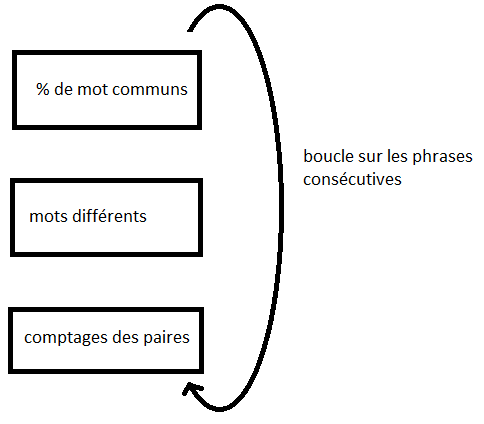

In [ ]:
from pyquickhelper.helpgen import NbImage
NbImage("synoym.png")

On supprime les phrases qui incluent des espaces entre chaque lettre. On a la choix entre les garder, les jeter ou les corriger. On choisit l'option la plus simple : les jeter quitte à y revenir plus tard. Si un espace existe en chaque lettre, cela veut que le nombre de lettres (sans espace) est égal au nombre de mot.

In [ ]:
garde = []
for line in lines:
    nbchar = len(line.replace(" ", ""))
    nbword = len(line.split())
    if nbchar > nbword:
        garde.append(line)
len(garde), len(lines)

(29378, 32358)

In [ ]:
garde[:5]

['copyright laws for your country before downloading doré redistributing',
 'copyright laws for your country before downloading or redistributing',
 'this or any other project gutenberg file',
 'this or any other project gutenberg file',
 'do not change or edit it without written permission']

On découpe en mot avec la fonction [split](https://docs.python.org/3.4/library/stdtypes.html#str.split) :

In [ ]:
mots = [line.split() for line in garde]
mots[:5]

[['copyright',
  'laws',
  'for',
  'your',
  'country',
  'before',
  'downloading',
  'doré',
  'redistributing'],
 ['copyright',
  'laws',
  'for',
  'your',
  'country',
  'before',
  'downloading',
  'or',
  'redistributing'],
 ['this', 'or', 'any', 'other', 'project', 'gutenberg', 'file'],
 ['this', 'or', 'any', 'other', 'project', 'gutenberg', 'file'],
 ['do',
  'not',
  'change',
  'or',
  'edit',
  'it',
  'without',
  'written',
  'permission']]

On code les petits bouts :

In [ ]:
def pourcentage_mots_communs(p1, p2):
    n = 0
    for p in p1:
        if p in p2:
            n += 1
    return n * 1.0 / max(len(p1),len(p2))

p1, p2 = mots[0:2]
print(p1)
print(p2)
pourcentage_mots_communs(p1, p2)

['copyright', 'laws', 'for', 'your', 'country', 'before', 'downloading', 'doré', 'redistributing']
['copyright', 'laws', 'for', 'your', 'country', 'before', 'downloading', 'or', 'redistributing']


0.8888888888888888

Et l'autre :

In [ ]:
def mots_differents(p1, p2):
    diff1 = []
    for p in p1:
        if p not in p2:
            diff1.append(p)
    diff2 = []
    for p in p2:
        if p not in p1:
            diff2.append(p)
    return diff1, diff2

#p1, p2 = mots[0:2]
p1, p2 = ["a", "a", "b", "c"], ["a", "f", "g"]
print(p1)
print(p2)
mots_differents(p1, p2)

['a', 'a', 'b', 'c']
['a', 'f', 'g']


(['b', 'c'], ['f', 'g'])

Pour la boucle final, on procède par étape, on affiche des résultats intermédiaires : 

In [ ]:
for i in range(0,len(mots)):
    p1 = mots[i]
    p2 = mots[i+1]
    print("----")
    print(p1)
    print(p2)
    print(pourcentage_mots_communs(p1,p2))
    print(mots_differents(p1,p2))
    if i > 3 :
        break

----
['copyright', 'laws', 'for', 'your', 'country', 'before', 'downloading', 'doré', 'redistributing']
['copyright', 'laws', 'for', 'your', 'country', 'before', 'downloading', 'or', 'redistributing']
0.8888888888888888
(['doré'], ['or'])
----
['copyright', 'laws', 'for', 'your', 'country', 'before', 'downloading', 'or', 'redistributing']
['this', 'or', 'any', 'other', 'project', 'gutenberg', 'file']
0.1111111111111111
(['copyright', 'laws', 'for', 'your', 'country', 'before', 'downloading', 'redistributing'], ['this', 'any', 'other', 'project', 'gutenberg', 'file'])
----
['this', 'or', 'any', 'other', 'project', 'gutenberg', 'file']
['this', 'or', 'any', 'other', 'project', 'gutenberg', 'file']
1.0
([], [])
----
['this', 'or', 'any', 'other', 'project', 'gutenberg', 'file']
['do', 'not', 'change', 'or', 'edit', 'it', 'without', 'written', 'permission']
0.1111111111111111
(['this', 'any', 'other', 'project', 'gutenberg', 'file'], ['do', 'not', 'change', 'edit', 'it', 'without', 'writte

On complète cette première boucle en supposant qu'une bonne paire de synonymes doit provenir d'une paire de mots ayant en pourcentage de mots communs supérieur à 50% et une seule paire de synonymes :

In [ ]:
compteur = {}
for i in range(0,len(mots)-1):
    p1 = mots[i]
    p2 = mots[i+1]
    if pourcentage_mots_communs(p1, p2) >= 0.5:
        diff1, diff2 = mots_differents(p1, p2)
        if len(diff1) == len(diff2) == 1:
            m1 = diff1[0]
            m2 = diff2[0]
            l = [m1, m2]
            l.sort()  # on trie les deux mots pour aggréger les deux paires m1, m2 et m2, m1
            key = tuple(l)  # une liste ne peut être la clé d'un dictionnaire
            if key not in compteur:
                compteur[key] = 0
            compteur[key] += 1

On regarde le résultat en triant par ordre de fréquence décroissante :

In [ ]:
l = [ (compteur[k],k) for k in compteur]
l[:5]

[(1, ('dangereux', 'précaire')),
 (1, ('autoriser', 'être')),
 (1, ('alors', 'ok')),
 (1, ('cogitation', 'considération')),
 (1, ('différencier', 'gouverner'))]

In [ ]:
l.sort(reverse=True)
l[:20]

[(149, ('lombric', 'terre')),
 (149, ('de', 'lombric')),
 (142, ('terre', 'ver')),
 (141, ('de', 'terre')),
 (137, ('de', 'ver')),
 (118, ('lombric', 'ver')),
 (61, ('du', 'flétan')),
 (42, ('trois', 'un')),
 (41, ('1', 'trois')),
 (34, ('1', 'un')),
 (33, ('ne', 'niet')),
 (32, ('ne', 'non')),
 (31, ('niet', 'pas')),
 (31, ('1', '10')),
 (30, ('parlement', 'voix')),
 (29, ('doré', 'or')),
 (29, ('10', 'trois')),
 (28, ('son', 'élu')),
 (28, ('son', 'voix')),
 (27, ('non', 'pas'))]

## Vérifications

Ces mots ne paraissent pas très pertinents au regard de la langue française. La méthode est néanmoins valable si elle permet de retrouver des synonymes qui ont permis de générer ce texte *zadig_augmente.txt*.

In [ ]:
allsyn.get("lombric", None)

{'de', 'lombric', 'terre', 'ver'}

In [ ]:
allsyn.get("flétan", None)

{'du', 'elbot', 'flétan'}

In [ ]:
allsyn.get("niet", None)

{'ne', 'niet', 'non', 'pas'}

## Améliorations

### stop words

In [ ]:
stopwords = {"de", "ou", "a", "un", "du"}
compteur = {}
for i in range(0,len(mots)-1):
    p1 = mots[i]
    p2 = mots[i+1]
    if pourcentage_mots_communs(p1, p2) >= 0.5:
        diff1, diff2 = mots_differents(p1, p2)
        if len(diff1) == len(diff2) == 1:
            m1 = diff1[0]
            m2 = diff2[0]
            if m1 not in  stopwords and m2 not in stopwords:
                l = [m1, m2]
                l.sort()
                key = tuple(l)
                if key not in compteur:
                    compteur[key] = 0
                compteur[key] += 1

In [ ]:
l = [ (compteur[k],k) for k in compteur]
l.sort(reverse=True)
l[:20]

[(149, ('lombric', 'terre')),
 (142, ('terre', 'ver')),
 (118, ('lombric', 'ver')),
 (41, ('1', 'trois')),
 (33, ('ne', 'niet')),
 (32, ('ne', 'non')),
 (31, ('niet', 'pas')),
 (31, ('1', '10')),
 (30, ('parlement', 'voix')),
 (29, ('doré', 'or')),
 (29, ('10', 'trois')),
 (28, ('son', 'élu')),
 (28, ('son', 'voix')),
 (27, ('non', 'pas')),
 (25, ('lorsque', 'que')),
 (23, ('voix', 'élu')),
 (21, ('parlement', 'son')),
 (21, ('même', 'que')),
 (21, ('en', 'ultérieurement')),
 (21, ('abeilles', 'reine'))]

### prise en compte de plus ligne

Et pas seulement deux lignes consécutives

In [ ]:
stopwords = {"de", "ou", "a", "un", "du"}
compteur = {}
for i in range(0,len(mots)-1):
    p1 = mots[i]
    for k in range(0,10):
        if i+k >= len(mots):
            break
        p2 = mots[i+k]
        if pourcentage_mots_communs(p1, p2) >= 0.5:
            diff1, diff2 = mots_differents(p1, p2)
            if len(diff1) == len(diff2) == 1:
                m1 = diff1[0]
                m2 = diff2[0]
                if m1 not in  stopwords and m2 not in stopwords:
                    l = [m1, m2]
                    l.sort()
                    key = tuple(l)
                    if key not in compteur:
                        compteur[key] = 0
                    compteur[key] += 1

In [ ]:
l = [ (compteur[k],k) for k in compteur]
l.sort(reverse=True)
l[:20]

[(418, ('terre', 'ver')),
 (393, ('lombric', 'ver')),
 (392, ('lombric', 'terre')),
 (111, ('1', 'trois')),
 (110, ('10', 'trois')),
 (99, ('ne', 'niet')),
 (97, ('niet', 'pas')),
 (91, ('parlement', 'voix')),
 (91, ('ne', 'non')),
 (85, ('lorsque', 'que')),
 (83, ('son', 'élu')),
 (82, ('non', 'pas')),
 (80, ('1', '10')),
 (78, ('voix', 'élu')),
 (77, ('quand', 'que')),
 (77, ('ne', 'pas')),
 (77, ('lorsque', 'quand')),
 (76, ('niet', 'non')),
 (75, ('même', 'que')),
 (72, ('son', 'voix'))]

Ca ne change pas grand compte tenu de la façon dont la base a été construite.